Resources Needed:
<br>
* resources/US_Accidents_Dec20_Updated.csv
* resources/{year}_vehicle_reg.xlsx
* resources/state_population_data_july2020.csv
* output_tables/road_distance_by_state.csv
* output_tables/land_area_by_state.csv
* resources/blue_laws.csv
* output_tables/weed_legalization_raw_scrape.csv

This notebook can take up to 1min to run, most of the time is spent importing the US_Accidents_Dec20_Updated dataset.

In [1]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
new_states = {v:k for k,v in us_state_abbrev.items()}

In [2]:
import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Import Accident Dataset (1GB)

In [3]:
accidents = pd.read_csv('resources/US_Accidents_Dec20_Updated.csv')
dropthese = ['ID', 'End_Lat', 'End_Lng', 'End_Time', 'Description']
accidents = accidents.drop(columns = dropthese, axis = 1)
accidents['Start_Time'] = pd.to_datetime(accidents['Start_Time'])
accidents.head()

,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Number,Street,Side,City,County,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,2,2019-05-21 08:29:55,34.808868,-82.269157,0.0,439.0,Tanner Rd,R,Greenville,Greenville,...,False,False,False,False,False,False,Day,Day,Day,Day
1,2,2019-10-07 17:43:09,35.090080,-80.745560,0.0,3299.0,Providence Branch Ln,R,Charlotte,Mecklenburg,...,False,False,False,False,False,False,Day,Day,Day,Day
2,2,2020-12-13 21:53:00,37.145730,-121.985052,1.4,NaN,Santa Cruz Hwy,R,Los Gatos,Santa Clara,...,False,False,False,False,False,False,Night,Night,Night,Night
3,2,2018-04-17 16:51:23,39.110390,-119.773781,0.0,NaN,US Highway 395 S,R,Carson City,Douglas,...,False,False,False,False,True,False,Day,Day,Day,Day
4,3,2016-08-31 17:40:49,26.102942,-80.265091,0.0,NaN,I-595 W,R,Fort Lauderdale,Broward,...,False,False,False,False,True,False,Day,Day,Day,Day


In [4]:
len(accidents.index)

2906610

# Function to make Datasets of Accidents by Year (Joined with Vehicle Registration Data of the same year)

In [5]:
def make_df_by_year(year):
    
    registrations = pd.read_excel(f'resources/{year}_vehicle_reg.xlsx', header = 7)
    registrations.columns = [str(i) for i in range(len(registrations.columns))]
    registrations = registrations.set_index('0')

    col1 = ['Automobiles','Buses','Trucks','Motorcycles','All Vehicles']
    col2 = ['PRIVATE/COMMERCIAL','PUBLICALLY_OWNED','TOTAL']
    col_tier = []
    for i in col1:
        for j in col2:
            col_tier.append((i,j))
    registrations.columns = pd.MultiIndex.from_tuples(col_tier)
    starting_point = registrations.index.to_list().index('Alabama')
    registrations = registrations[starting_point:].dropna()

    for i in registrations.columns:
        registrations[i] = pd.to_numeric(registrations[i])
    
    
    year_start = f"{year}-01-01"
    year_end = f"{year+1}-01-01"
    accidents_output = accidents[(accidents['Start_Time'] > year_start) & (accidents['Start_Time'] < year_end)]
    
    transform = accidents_output.groupby(['State','Severity']).count()['Start_Time'].reset_index().rename(columns = {'Start_Time':'Count'})

    count_crashes = accidents_output[['State','Severity']].groupby(['State']).count()
    count_crashes = count_crashes.reset_index()
    count_crashes['State'] = count_crashes['State'].apply(lambda x: new_states[x])
    
    #-- Make Severity
    severity_1 = []
    severity_2 = []
    severity_3 = []
    severity_4 = []

    states = list(transform['State'].unique())
    for i in states:
        state_only = transform[transform['State'] == i]
        sev_1 = state_only[state_only['Severity'] == 1]
        sev_2 = state_only[state_only['Severity'] == 2]
        sev_3 = state_only[state_only['Severity'] == 3]
        sev_4 = state_only[state_only['Severity'] == 4]

        if len(sev_1.index) > 0:
            severity_1.append(int(sev_1['Count']))
        else:
            severity_1.append(0)

        if len(sev_2.index) > 0:
            severity_2.append(int(sev_2['Count']))
        else:
            severity_2.append(0)

        if len(sev_3.index) > 0:
            severity_3.append(int(sev_3['Count']))
        else:
            severity_3.append(0)

        if len(sev_4.index) > 0:
            severity_4.append(int(sev_4['Count']))
        else:
            severity_4.append(0)
            
    state_by_severity = pd.DataFrame({'State': list(transform['State'].unique()),
             'Severity_1': severity_1,
             'Severity_2': severity_2,
             'Severity_3': severity_3,
             'Severity_4': severity_4})
    
    state_by_severity['State'] = state_by_severity['State'].apply(lambda x: new_states[x])
    count_crashes.columns = ['State','Crash Count']
    
    check = registrations['All Vehicles']['TOTAL'].to_dict()
    new_keys = []
    for k,v in check.items():
        if k.endswith(' '):
            new_keys.append(k[:-1])
        elif k.endswith(' (2)'):
            new_keys.append(k.replace(' (2)',''))
        else:
            new_keys.append(k)

    new_out = {}
    for i,j in enumerate(check.values()):
        new_out[new_keys[i]] = j
    new_out['District of Columbia'] = new_out.pop('Dist. of Col.')

    new_out.pop('Total')
    
    new_out = {
        'State': list(new_out.keys()),
        'Registered_Vehicles': list(new_out.values())
    }
    
    vehicle_reg = pd.DataFrame(new_out)
    crash_reg = count_crashes.merge(vehicle_reg, how = 'left', on = 'State').merge(state_by_severity, how = 'left', on ='State')
    crash_reg['Crash_Index'] = crash_reg['Crash Count']/ crash_reg['Registered_Vehicles']
    return crash_reg

# Make DFs with the above function

In [6]:
seventeen = make_df_by_year(2017)
eighteen = make_df_by_year(2018)
nineteen = make_df_by_year(2019)

In [7]:
seventeen.head()

,State,Crash Count,Registered_Vehicles,Severity_1,Severity_2,Severity_3,Severity_4,Crash_Index
0,Alabama,1813,5.056073e+06,3,837,842,131,0.000359
1,Arkansas,95,2.833697e+06,0,29,13,53,0.000034
2,Arizona,7976,5.964434e+06,4,5706,1417,849,0.001337
3,California,95651,3.079514e+07,39,62232,31791,1589,0.003106
4,Colorado,4702,5.259960e+06,1,2848,1162,691,0.000894


In [8]:
eighteen.head()

,State,Crash Count,Registered_Vehicles,Severity_1,Severity_2,Severity_3,Severity_4,Crash_Index
0,Alabama,7544,5.300199e+06,7,4529,2857,151,0.001423
1,Arkansas,491,2.817145e+06,0,201,98,192,0.000174
2,Arizona,13138,5.806313e+06,2,9479,2803,854,0.002263
3,California,98862,3.102233e+07,23,63912,33351,1576,0.003187
4,Colorado,8981,5.356018e+06,1,4842,3344,794,0.001677


In [9]:
nineteen.head()

,State,Crash Count,Registered_Vehicles,Severity_1,Severity_2,Severity_3,Severity_4,Crash_Index
0,Alabama,10148,5.288208e+06,2,7525,2471,150,0.001919
1,Arkansas,925,2.902111e+06,0,516,227,182,0.000319
2,Arizona,13633,5.982559e+06,3,10400,2379,851,0.002279
3,California,168526,3.124727e+07,9,140611,26024,1882,0.005393
4,Colorado,11920,5.412404e+06,1,4254,6455,1210,0.002202


In [10]:
avg_registered_vehicles = (seventeen['Registered_Vehicles'] + eighteen['Registered_Vehicles'] + nineteen['Registered_Vehicles']) / 3 
avg_crash_per_year = (seventeen['Crash Count'] + eighteen['Crash Count'] + nineteen['Crash Count']) / 3 

In [11]:
for i in list(seventeen.index):
    if i not in list(eighteen.index):
        print(f'not in eighteen: {i}')
    if i not in list(nineteen.index):
        print(f'not in nineteen: {i}')

# Combining Crash Indexes into one output

In [12]:
index_by_state = pd.DataFrame({'State':seventeen['State'].to_list(),
            'Crash_Count_YAvg': avg_crash_per_year,
            'Registered_Vehicles_Avg':avg_registered_vehicles})
index_by_state.head()

,State,Crash_Count_YAvg,Registered_Vehicles_Avg
0,Alabama,6501.666667,5.214827e+06
1,Arkansas,503.666667,2.850984e+06
2,Arizona,11582.333333,5.917769e+06
3,California,121013.000000,3.102158e+07
4,Colorado,8534.333333,5.342794e+06


# Importing Population Data

In [13]:
pop_data = pd.read_csv('resources/state_population_data_july2020.csv').drop(columns = ['SUMLEV', 'CENSUS2010POP', 'STATE','REGION','DIVISION'], axis = 1)
pop_data.head()

,NAME,SEX,ORIGIN,RACE,AGE,POPESTIMATE2019
0,Alabama,0,0,1,0,35594
1,Alabama,0,0,1,1,36679
2,Alabama,0,0,1,2,37904
3,Alabama,0,0,1,3,38510
4,Alabama,0,0,1,4,38476


# We only care about people over 16

## Please note: Sex "0" is total of Sex "1" and Sex "2", we do not need Sex "0"

We also have no crash data for Hawaii or Alaska, they will be dropped when the left merge happens

In [14]:
print(f"Length of Raw State Population Dataset: {len(pop_data.index)}")

Length of Raw State Population Dataset: 236844


In [15]:
pop_data = pop_data[(pop_data['AGE'] > 15) & (pop_data['SEX'] > 0)].rename(columns = {'NAME':'State'})
pop_data.head()

,State,SEX,ORIGIN,RACE,AGE,POPESTIMATE2019
1564,Alabama,1,0,1,16,20748
1565,Alabama,1,0,1,17,20711
1566,Alabama,1,0,1,18,20741
1567,Alabama,1,0,1,19,20398
1568,Alabama,1,0,1,20,20506


In [16]:
print(f"Length of Filtered State Population Dataset: {len(pop_data.index)}")

Length of Filtered State Population Dataset: 128520


# Total Pop per state by Sex

In [17]:
sex_by_state = pop_data.groupby(['State','SEX']).sum()['POPESTIMATE2019'].reset_index()
sex1 = sex_by_state[sex_by_state['SEX'] == 1][['State','POPESTIMATE2019']].rename(columns = {'POPESTIMATE2019':'Sex_1_Pop'})
sex2 = sex_by_state[sex_by_state['SEX'] == 2][['State','POPESTIMATE2019']].rename(columns = {'POPESTIMATE2019':'Sex_2_Pop'})
sexes = sex1.merge(sex2, how = 'left', on = 'State')
sexes.head()

,State,Sex_1_Pop,Sex_2_Pop
0,Alabama,3756166,4121078
1,Alaska,597262,543368
2,Arizona,5750252,5896632
3,Arkansas,2326922,2466136
4,California,31216500,32017116


# Total Pop per state by Race

In [18]:
race_by_state = pop_data.groupby(['RACE','State']).sum()['POPESTIMATE2019'].reset_index()

# making an output dataframe
out = {'State':race_by_state[race_by_state['RACE'] == 1]['State']}
for i in range(1, max(race_by_state['RACE'].unique()) + 1):
    title = f"Race_{i}_Pop"
    out[title] = race_by_state[race_by_state['RACE'] == i]['POPESTIMATE2019'].to_list()

race_by_state = pd.DataFrame(out)
race_by_state.head()

,State,Race_1_Pop,Race_2_Pop,Race_3_Pop,Race_4_Pop,Race_5_Pop,Race_6_Pop
0,Alabama,5535308,2060146,56634,118462,7804,98890
1,Alaska,779052,42656,161364,77782,15036,64740
2,Arizona,9774984,576770,559436,445012,31754,258928
3,Arkansas,3852758,720534,47704,79818,16024,76220
4,California,45476790,4126560,1024614,10277334,316162,2012156


# Total Pop per state by Origin

In [19]:
origin_by_state = pop_data.groupby(['ORIGIN','State']).sum()['POPESTIMATE2019'].reset_index()

# making an output dataframe
out = {'State':origin_by_state[origin_by_state['ORIGIN'] == 1]['State']}
for i in range(0, max(origin_by_state['ORIGIN'].unique()) + 1):
    title = f"Origin_{i}_Pop"
    out[title] = origin_by_state[origin_by_state['ORIGIN'] == i]['POPESTIMATE2019'].to_list()

origin_by_state = pd.DataFrame(out)
origin_by_state.head()

,State,Origin_0_Pop,Origin_1_Pop,Origin_2_Pop
51,Alabama,3938622,3796692,141930
52,Alaska,570315,533461,36854
53,Arizona,5823442,4161567,1661875
54,Arkansas,2396529,2239461,157068
55,California,31616808,20157843,11458965


# Merging Population Data

In [20]:
index_by_state = index_by_state.merge(sexes, how = 'left', on = 'State').merge(race_by_state, how = 'left', on = 'State').merge(origin_by_state, how = 'left', on = 'State')
index_by_state

,State,Crash_Count_YAvg,Registered_Vehicles_Avg,Sex_1_Pop,Sex_2_Pop,Race_1_Pop,Race_2_Pop,Race_3_Pop,Race_4_Pop,Race_5_Pop,Race_6_Pop,Origin_0_Pop,Origin_1_Pop,Origin_2_Pop
0,Alabama,6501.666667,5.214827e+06,3756166,4121078,5535308,2060146,56634,118462,7804,98890,3938622,3796692,141930
1,Arkansas,503.666667,2.850984e+06,2326922,2466136,3852758,720534,47704,79818,16024,76220,2396529,2239461,157068
2,Arizona,11582.333333,5.917769e+06,5750252,5896632,9774984,576770,559436,445012,31754,258928,5823442,4161567,1661875
3,California,121013.000000,3.102158e+07,31216500,32017116,45476790,4126560,1024614,10277334,316162,2012156,31616808,20157843,11458965
4,Colorado,8534.333333,5.342794e+06,4662722,4623020,8158550,411162,141074,331014,17500,226442,4642871,3737570,905301
5,Connecticut,4148.333333,2.861566e+06,2829874,3028820,4744064,685310,31340,285658,6164,106158,2929347,2492559,436788
6,District of Columbia,737.333333,3.494706e+05,549872,625840,563666,520262,6380,56520,1360,27524,587856,528635,59221
7,Delaware,857.333333,9.987093e+05,759230,827602,1127352,352688,10262,64686,1554,30290,793416,730203,63213
8,Florida,38067.000000,1.742966e+07,17161930,18287566,27977026,5612238,177870,1062616,39046,580700,17724748,13270067,4454681
9,Georgia,14606.000000,8.516481e+06,8065024,8739416,10327490,5363292,84242,744524,18066,266826,8402220,7690632,711588


# Making a Total_Population Column

In [21]:
population_columns = [i for i in index_by_state.columns if i.endswith('Pop')]

total_pop = [0 for i in range(len(index_by_state.index))]
for i in population_columns:
    total_pop += index_by_state[i]
    
index_by_state['Total_2019_Pop'] = total_pop

# Importing Calculated Road Distance Dataset

In [22]:
road_dist = pd.read_csv('output_tables/road_distance_by_state.csv').rename(columns = {'state_name':'State'})
road_dist['sum_interstate_distance'] = road_dist['sum_interstate_distance'] * 3
road_dist['sum_highway_distance'] = road_dist['sum_highway_distance'] * 2
road_dist.head()

,State,sum_interstate_distance,sum_highway_distance,sum_other_distance
0,Alabama,108.709435,168.630342,2055.135931
1,Arizona,119.118217,75.794702,1519.798416
2,Arkansas,72.395813,172.517366,2121.400732
3,California,244.633953,93.074124,4664.484637
4,Colorado,104.273956,210.519735,2022.606169


In [23]:
index_by_state = index_by_state.merge(road_dist, how = 'left', on = 'State')
index_by_state

,State,Crash_Count_YAvg,Registered_Vehicles_Avg,Sex_1_Pop,Sex_2_Pop,Race_1_Pop,Race_2_Pop,Race_3_Pop,Race_4_Pop,Race_5_Pop,Race_6_Pop,Origin_0_Pop,Origin_1_Pop,Origin_2_Pop,Total_2019_Pop,sum_interstate_distance,sum_highway_distance,sum_other_distance
0,Alabama,6501.666667,5.214827e+06,3756166,4121078,5535308,2060146,56634,118462,7804,98890,3938622,3796692,141930,23631732,108.709435,168.630342,2055.135931
1,Arkansas,503.666667,2.850984e+06,2326922,2466136,3852758,720534,47704,79818,16024,76220,2396529,2239461,157068,14379174,72.395813,172.517366,2121.400732
2,Arizona,11582.333333,5.917769e+06,5750252,5896632,9774984,576770,559436,445012,31754,258928,5823442,4161567,1661875,34940652,119.118217,75.794702,1519.798416
3,California,121013.000000,3.102158e+07,31216500,32017116,45476790,4126560,1024614,10277334,316162,2012156,31616808,20157843,11458965,189700848,244.633953,93.074124,4664.484637
4,Colorado,8534.333333,5.342794e+06,4662722,4623020,8158550,411162,141074,331014,17500,226442,4642871,3737570,905301,27857226,104.273956,210.519735,2022.606169
5,Connecticut,4148.333333,2.861566e+06,2829874,3028820,4744064,685310,31340,285658,6164,106158,2929347,2492559,436788,17576082,35.728563,22.533191,471.569466
6,District of Columbia,737.333333,3.494706e+05,549872,625840,563666,520262,6380,56520,1360,27524,587856,528635,59221,3527136,1.188612,1.643633,20.552629
7,Delaware,857.333333,9.987093e+05,759230,827602,1127352,352688,10262,64686,1554,30290,793416,730203,63213,4760496,4.170596,14.776965,207.438202
8,Florida,38067.000000,1.742966e+07,17161930,18287566,27977026,5612238,177870,1062616,39046,580700,17724748,13270067,4454681,106348488,139.832291,222.032022,3012.123448
9,Georgia,14606.000000,8.516481e+06,8065024,8739416,10327490,5363292,84242,744524,18066,266826,8402220,7690632,711588,50413320,118.769858,248.793350,2834.434202


# Importing the Land Area Dataset made by the SrapingLandArea_byState.ipynb file

In [24]:
land_area = pd.read_csv('output_tables/land_area_by_state.csv')
land_area.head()

,State,Total_SqMi,Total_SqKm,LandArea_SqMi,LandArea_SqKm
0,Alabama,52420,135767,50645,131171
1,Alaska,665384,1723337,570641,1477953
2,Arizona,113990,295234,113594,294207
3,Arkansas,53179,137732,52035,134771
4,California,163695,423967,155779,403466


# We only care about the LandArea_SqMi Column

In [25]:
land_area = land_area[['State','LandArea_SqMi']]
land_area.head()

,State,LandArea_SqMi
0,Alabama,50645
1,Alaska,570641
2,Arizona,113594
3,Arkansas,52035
4,California,155779


In [26]:
index_by_state = index_by_state.merge(land_area, how = 'left',on = 'State')
index_by_state

,State,Crash_Count_YAvg,Registered_Vehicles_Avg,Sex_1_Pop,Sex_2_Pop,Race_1_Pop,Race_2_Pop,Race_3_Pop,Race_4_Pop,Race_5_Pop,Race_6_Pop,Origin_0_Pop,Origin_1_Pop,Origin_2_Pop,Total_2019_Pop,sum_interstate_distance,sum_highway_distance,sum_other_distance,LandArea_SqMi
0,Alabama,6501.666667,5.214827e+06,3756166,4121078,5535308,2060146,56634,118462,7804,98890,3938622,3796692,141930,23631732,108.709435,168.630342,2055.135931,50645
1,Arkansas,503.666667,2.850984e+06,2326922,2466136,3852758,720534,47704,79818,16024,76220,2396529,2239461,157068,14379174,72.395813,172.517366,2121.400732,52035
2,Arizona,11582.333333,5.917769e+06,5750252,5896632,9774984,576770,559436,445012,31754,258928,5823442,4161567,1661875,34940652,119.118217,75.794702,1519.798416,113594
3,California,121013.000000,3.102158e+07,31216500,32017116,45476790,4126560,1024614,10277334,316162,2012156,31616808,20157843,11458965,189700848,244.633953,93.074124,4664.484637,155779
4,Colorado,8534.333333,5.342794e+06,4662722,4623020,8158550,411162,141074,331014,17500,226442,4642871,3737570,905301,27857226,104.273956,210.519735,2022.606169,103642
5,Connecticut,4148.333333,2.861566e+06,2829874,3028820,4744064,685310,31340,285658,6164,106158,2929347,2492559,436788,17576082,35.728563,22.533191,471.569466,4842
6,District of Columbia,737.333333,3.494706e+05,549872,625840,563666,520262,6380,56520,1360,27524,587856,528635,59221,3527136,1.188612,1.643633,20.552629,61
7,Delaware,857.333333,9.987093e+05,759230,827602,1127352,352688,10262,64686,1554,30290,793416,730203,63213,4760496,4.170596,14.776965,207.438202,1949
8,Florida,38067.000000,1.742966e+07,17161930,18287566,27977026,5612238,177870,1062616,39046,580700,17724748,13270067,4454681,106348488,139.832291,222.032022,3012.123448,53625
9,Georgia,14606.000000,8.516481e+06,8065024,8739416,10327490,5363292,84242,744524,18066,266826,8402220,7690632,711588,50413320,118.769858,248.793350,2834.434202,57513


# Blue Laws
Source: https://worldpopulationreview.com/state-rankings/blue-laws-by-state
<br>
Binning by whether or not a state has restrictive measures against alcohol
<br>
### 0 = No Blue Laws, 1 = Some, 2 = Statewide

In [27]:
blue_df = pd.read_csv('resources/blue_laws.csv')
blue_df.blueLaws.value_counts()

No blue laws                       20
No vehicle sales                   11
Varies by County                   10
No hard liquor sales                5
No off-premise sales                3
No vehicle or hard liquor sales     1
Name: blueLaws, dtype: int64

In [28]:
blue_df.head()

,State,blueLaws
0,Oklahoma,Varies by County
1,New Mexico,Varies by County
2,Mississippi,Varies by County
3,Maryland,Varies by County
4,Louisiana,Varies by County


In [29]:
zeros = ['No blue laws',
        'No vehicle sales']
blue_df['blueLaws'] = blue_df['blueLaws'].apply(lambda x: 0 if x in zeros else 1 if x == 'Varies by County' else 2)
blue_df = blue_df.sort_values('State')
blue_df

,State,blueLaws
9,Alabama,1
49,Alaska,0
48,Arizona,0
8,Arkansas,1
47,California,0
20,Colorado,0
46,Connecticut,0
45,Delaware,0
7,Florida,1
6,Georgia,1


In [30]:
index_by_state = index_by_state.merge(blue_df, how = 'left', on = 'State')
index_by_state['blueLaws'] = index_by_state['blueLaws'].fillna(0).apply(lambda x: int(x))
index_by_state

,State,Crash_Count_YAvg,Registered_Vehicles_Avg,Sex_1_Pop,Sex_2_Pop,Race_1_Pop,Race_2_Pop,Race_3_Pop,Race_4_Pop,Race_5_Pop,Race_6_Pop,Origin_0_Pop,Origin_1_Pop,Origin_2_Pop,Total_2019_Pop,sum_interstate_distance,sum_highway_distance,sum_other_distance,LandArea_SqMi,blueLaws
0,Alabama,6501.666667,5.214827e+06,3756166,4121078,5535308,2060146,56634,118462,7804,98890,3938622,3796692,141930,23631732,108.709435,168.630342,2055.135931,50645,1
1,Arkansas,503.666667,2.850984e+06,2326922,2466136,3852758,720534,47704,79818,16024,76220,2396529,2239461,157068,14379174,72.395813,172.517366,2121.400732,52035,1
2,Arizona,11582.333333,5.917769e+06,5750252,5896632,9774984,576770,559436,445012,31754,258928,5823442,4161567,1661875,34940652,119.118217,75.794702,1519.798416,113594,0
3,California,121013.000000,3.102158e+07,31216500,32017116,45476790,4126560,1024614,10277334,316162,2012156,31616808,20157843,11458965,189700848,244.633953,93.074124,4664.484637,155779,0
4,Colorado,8534.333333,5.342794e+06,4662722,4623020,8158550,411162,141074,331014,17500,226442,4642871,3737570,905301,27857226,104.273956,210.519735,2022.606169,103642,0
5,Connecticut,4148.333333,2.861566e+06,2829874,3028820,4744064,685310,31340,285658,6164,106158,2929347,2492559,436788,17576082,35.728563,22.533191,471.569466,4842,0
6,District of Columbia,737.333333,3.494706e+05,549872,625840,563666,520262,6380,56520,1360,27524,587856,528635,59221,3527136,1.188612,1.643633,20.552629,61,0
7,Delaware,857.333333,9.987093e+05,759230,827602,1127352,352688,10262,64686,1554,30290,793416,730203,63213,4760496,4.170596,14.776965,207.438202,1949,0
8,Florida,38067.000000,1.742966e+07,17161930,18287566,27977026,5612238,177870,1062616,39046,580700,17724748,13270067,4454681,106348488,139.832291,222.032022,3012.123448,53625,1
9,Georgia,14606.000000,8.516481e+06,8065024,8739416,10327490,5363292,84242,744524,18066,266826,8402220,7690632,711588,50413320,118.769858,248.793350,2834.434202,57513,1


# Importing Weed Legalization Data per State

In [31]:
weed = pd.read_csv('output_tables/weed_legalization_raw_scrape.csv').drop(columns = 'State Laws')
weed.columns = ['State','Weed_Legalization','Medicinal_Weed_Available','Weed_Decriminalized']

In [32]:
index_by_state = index_by_state.merge(weed, how = 'left', on = 'State')
index_by_state

,State,Crash_Count_YAvg,Registered_Vehicles_Avg,Sex_1_Pop,Sex_2_Pop,Race_1_Pop,Race_2_Pop,Race_3_Pop,Race_4_Pop,Race_5_Pop,...,Origin_2_Pop,Total_2019_Pop,sum_interstate_distance,sum_highway_distance,sum_other_distance,LandArea_SqMi,blueLaws,Weed_Legalization,Medicinal_Weed_Available,Weed_Decriminalized
0,Alabama,6501.666667,5.214827e+06,3756166,4121078,5535308,2060146,56634,118462,7804,...,141930,23631732,108.709435,168.630342,2055.135931,50645,1,Mixed,Yes,No
1,Arkansas,503.666667,2.850984e+06,2326922,2466136,3852758,720534,47704,79818,16024,...,157068,14379174,72.395813,172.517366,2121.400732,52035,1,Mixed,Yes,No
2,Arizona,11582.333333,5.917769e+06,5750252,5896632,9774984,576770,559436,445012,31754,...,1661875,34940652,119.118217,75.794702,1519.798416,113594,0,Fully Legal,Yes,Yes
3,California,121013.000000,3.102158e+07,31216500,32017116,45476790,4126560,1024614,10277334,316162,...,11458965,189700848,244.633953,93.074124,4664.484637,155779,0,Fully Legal,Yes,Yes
4,Colorado,8534.333333,5.342794e+06,4662722,4623020,8158550,411162,141074,331014,17500,...,905301,27857226,104.273956,210.519735,2022.606169,103642,0,Fully Legal,Yes,Yes
5,Connecticut,4148.333333,2.861566e+06,2829874,3028820,4744064,685310,31340,285658,6164,...,436788,17576082,35.728563,22.533191,471.569466,4842,0,Mixed,Yes,Yes
6,District of Columbia,737.333333,3.494706e+05,549872,625840,563666,520262,6380,56520,1360,...,59221,3527136,1.188612,1.643633,20.552629,61,0,Fully Legal,Yes,Yes
7,Delaware,857.333333,9.987093e+05,759230,827602,1127352,352688,10262,64686,1554,...,63213,4760496,4.170596,14.776965,207.438202,1949,0,Mixed,Yes,Yes
8,Florida,38067.000000,1.742966e+07,17161930,18287566,27977026,5612238,177870,1062616,39046,...,4454681,106348488,139.832291,222.032022,3012.123448,53625,1,Mixed,Yes,No
9,Georgia,14606.000000,8.516481e+06,8065024,8739416,10327490,5363292,84242,744524,18066,...,711588,50413320,118.769858,248.793350,2834.434202,57513,1,Mixed,CBD Oil Only,No


# Bucketing Avg Severity by State Because Sam Young is Smart

In [33]:
import matplotlib.pyplot as plt

In [34]:
avg_severity = accidents.groupby('State').mean()['Severity'].reset_index()

<AxesSubplot:ylabel='Density'>

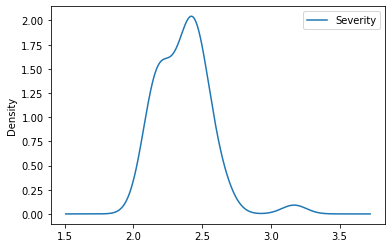

In [35]:
avg_severity.plot.density()

In [36]:
print(f"bottom:     {min(avg_severity['Severity'].to_list())}")
print(f"quartile 1: {avg_severity['Severity'].quantile(q=0.25)}")
print(f"quartile 2: {avg_severity['Severity'].quantile(q=0.50)}")
print(f"quartile 3: {avg_severity['Severity'].quantile(q=0.75)}")

bottom:     2.062634989200864
quartile 1: 2.20128
quartile 2: 2.3824807756603144
quartile 3: 2.471103556485356


In [37]:
def danger_bucket(dataset):
    
    bottom = min(dataset['Severity'].to_list())
    quart1 = dataset['Severity'].quantile(q=0.25)
    quart2 = dataset['Severity'].quantile(q=0.50)
    quart3 = dataset['Severity'].quantile(q=0.75)

    list_to_convert = dataset['Severity'].to_list()
    
    output = []
    for i in list_to_convert:
        if i >= quart3:
            output.append('High Severity')
        elif i >= quart2:
            output.append('Med-High Severity')
        elif i >= quart1:
            output.append('Medium Severity')
        else:
            output.append('Low Severity')
    return output

In [38]:
avg_severity['Severity_cat'] = danger_bucket(avg_severity)
avg_severity['State'] = avg_severity['State'].apply(lambda x: new_states[x])

In [39]:
avg_severity

,State,Severity,Severity_cat
0,Alabama,2.292250,Medium Severity
1,Arkansas,2.382141,Medium Severity
2,Arizona,2.144376,Low Severity
3,California,2.202665,Medium Severity
4,Colorado,2.609979,High Severity
5,Connecticut,2.515174,High Severity
6,District of Columbia,2.412998,Med-High Severity
7,Delaware,2.488000,High Severity
8,Florida,2.248777,Medium Severity
9,Georgia,2.633355,High Severity


In [40]:
index_by_state = index_by_state.merge(avg_severity, how = 'left', on = 'State').rename(columns = {'Severity':'Severity_avg'})
index_by_state

,State,Crash_Count_YAvg,Registered_Vehicles_Avg,Sex_1_Pop,Sex_2_Pop,Race_1_Pop,Race_2_Pop,Race_3_Pop,Race_4_Pop,Race_5_Pop,...,sum_interstate_distance,sum_highway_distance,sum_other_distance,LandArea_SqMi,blueLaws,Weed_Legalization,Medicinal_Weed_Available,Weed_Decriminalized,Severity_avg,Severity_cat
0,Alabama,6501.666667,5.214827e+06,3756166,4121078,5535308,2060146,56634,118462,7804,...,108.709435,168.630342,2055.135931,50645,1,Mixed,Yes,No,2.292250,Medium Severity
1,Arkansas,503.666667,2.850984e+06,2326922,2466136,3852758,720534,47704,79818,16024,...,72.395813,172.517366,2121.400732,52035,1,Mixed,Yes,No,2.382141,Medium Severity
2,Arizona,11582.333333,5.917769e+06,5750252,5896632,9774984,576770,559436,445012,31754,...,119.118217,75.794702,1519.798416,113594,0,Fully Legal,Yes,Yes,2.144376,Low Severity
3,California,121013.000000,3.102158e+07,31216500,32017116,45476790,4126560,1024614,10277334,316162,...,244.633953,93.074124,4664.484637,155779,0,Fully Legal,Yes,Yes,2.202665,Medium Severity
4,Colorado,8534.333333,5.342794e+06,4662722,4623020,8158550,411162,141074,331014,17500,...,104.273956,210.519735,2022.606169,103642,0,Fully Legal,Yes,Yes,2.609979,High Severity
5,Connecticut,4148.333333,2.861566e+06,2829874,3028820,4744064,685310,31340,285658,6164,...,35.728563,22.533191,471.569466,4842,0,Mixed,Yes,Yes,2.515174,High Severity
6,District of Columbia,737.333333,3.494706e+05,549872,625840,563666,520262,6380,56520,1360,...,1.188612,1.643633,20.552629,61,0,Fully Legal,Yes,Yes,2.412998,Med-High Severity
7,Delaware,857.333333,9.987093e+05,759230,827602,1127352,352688,10262,64686,1554,...,4.170596,14.776965,207.438202,1949,0,Mixed,Yes,Yes,2.488000,High Severity
8,Florida,38067.000000,1.742966e+07,17161930,18287566,27977026,5612238,177870,1062616,39046,...,139.832291,222.032022,3012.123448,53625,1,Mixed,Yes,No,2.248777,Medium Severity
9,Georgia,14606.000000,8.516481e+06,8065024,8739416,10327490,5363292,84242,744524,18066,...,118.769858,248.793350,2834.434202,57513,1,Mixed,CBD Oil Only,No,2.633355,High Severity


# Finalizing the Crash Index Metric
### Currently, the Crash_Index_by_Registration column is the number of accidents / number of cars registered by state
### We will be incorporating the amount of roadways by Land Area per state to put more context into accidents per state

In [41]:
index_cols = ['State','Crash_Count_YAvg','Registered_Vehicles_Avg','LandArea_SqMi','sum_interstate_distance','sum_highway_distance','sum_other_distance']

In [42]:
index_by_state[index_cols].head()

,State,Crash_Count_YAvg,Registered_Vehicles_Avg,LandArea_SqMi,sum_interstate_distance,sum_highway_distance,sum_other_distance
0,Alabama,6501.666667,5.214827e+06,50645,108.709435,168.630342,2055.135931
1,Arkansas,503.666667,2.850984e+06,52035,72.395813,172.517366,2121.400732
2,Arizona,11582.333333,5.917769e+06,113594,119.118217,75.794702,1519.798416
3,California,121013.000000,3.102158e+07,155779,244.633953,93.074124,4664.484637
4,Colorado,8534.333333,5.342794e+06,103642,104.273956,210.519735,2022.606169


# Getting Total Road Distance

In [43]:
index_by_state['total_road_distance'] = index_by_state['sum_interstate_distance'] + index_by_state['sum_highway_distance'] + index_by_state['sum_other_distance']
index_cols.append('total_road_distance')
index_by_state[index_cols].head()

,State,Crash_Count_YAvg,Registered_Vehicles_Avg,LandArea_SqMi,sum_interstate_distance,sum_highway_distance,sum_other_distance,total_road_distance
0,Alabama,6501.666667,5.214827e+06,50645,108.709435,168.630342,2055.135931,2332.475708
1,Arkansas,503.666667,2.850984e+06,52035,72.395813,172.517366,2121.400732,2366.313911
2,Arizona,11582.333333,5.917769e+06,113594,119.118217,75.794702,1519.798416,1714.711335
3,California,121013.000000,3.102158e+07,155779,244.633953,93.074124,4664.484637,5002.192714
4,Colorado,8534.333333,5.342794e+06,103642,104.273956,210.519735,2022.606169,2337.399861


# Getting Road Distance by Land Area per State
Land Area value is given by the web scrape done in another notebook

In [44]:
testing = pd.DataFrame()
testing['State'] = index_by_state['State']
testing['accidents'] = index_by_state['Crash_Count_YAvg']
testing['registered_cars'] = index_by_state['Registered_Vehicles_Avg']
testing['land'] = index_by_state['LandArea_SqMi']
testing['all_road'] = index_by_state['total_road_distance']
testing['total_road_by_land'] = index_by_state['total_road_distance'] / index_by_state['LandArea_SqMi']
testing['interstate_by_land'] = index_by_state['sum_interstate_distance'] / index_by_state['LandArea_SqMi']
testing['highway_by_land'] = index_by_state['sum_highway_distance'] / index_by_state['LandArea_SqMi']
testing['danger'] = index_by_state['Severity_cat']
testing['pop'] = index_by_state['Total_2019_Pop']
testing.head()

,State,accidents,registered_cars,land,all_road,total_road_by_land,interstate_by_land,highway_by_land,danger,pop
0,Alabama,6501.666667,5.214827e+06,50645,2332.475708,0.046055,0.002146,0.003330,Medium Severity,23631732
1,Arkansas,503.666667,2.850984e+06,52035,2366.313911,0.045475,0.001391,0.003315,Medium Severity,14379174
2,Arizona,11582.333333,5.917769e+06,113594,1714.711335,0.015095,0.001049,0.000667,Low Severity,34940652
3,California,121013.000000,3.102158e+07,155779,5002.192714,0.032111,0.001570,0.000597,Medium Severity,189700848
4,Colorado,8534.333333,5.342794e+06,103642,2337.399861,0.022553,0.001006,0.002031,High Severity,27857226


In [173]:
testing['reg_vehicles_by_pop'] = (testing['registered_cars'] / testing['pop'])
testing[['State','total_road_by_land','reg_vehicles_by_pop']].sort_values('total_road_by_land')

,State,total_road_by_land,reg_vehicles_by_pop
31,Nevada,0.007048,0.169482
48,Wyoming,0.011613,0.302164
30,New Mexico,0.013724,0.178637
24,Montana,0.013772,0.356886
42,Utah,0.014631,0.167222
2,Arizona,0.015095,0.169366
11,Idaho,0.018532,0.226660
4,Colorado,0.022553,0.191792
35,Oregon,0.024631,0.192743
39,South Dakota,0.025376,0.306670


In [136]:
import math

In [200]:


testing['index'] = (testing['accidents'] / testing['registered_cars']) * (testing['all_road'] / testing['registered_cars']) * 100000
testing[['State','index','danger','reg_vehicles_by_pop']].sort_values('index')

,State,index,danger,reg_vehicles_by_pop
39,South Dakota,0.001949,Med-High Severity,0.306670
26,North Dakota,0.002715,Low Severity,0.265105
24,Montana,0.008150,Low Severity,0.356886
44,Vermont,0.013193,Med-High Severity,0.197418
6,District of Columbia,0.014118,Med-High Severity,0.099081
1,Arkansas,0.014663,Medium Severity,0.198272
17,Massachusetts,0.017361,Medium Severity,0.147942
48,Wyoming,0.017969,High Severity,0.302164
11,Idaho,0.018221,Low Severity,0.226660
7,Delaware,0.019459,High Severity,0.209791


<AxesSubplot:ylabel='Density'>

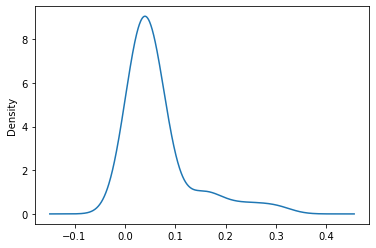

In [201]:
testing['index'].plot.density()

In [48]:
#index_by_state.to_csv('output_tables/data_grouped_by_state.csv', index = False)